In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten, \
                                    Dense, Conv2DTranspose,\
                                    BatchNormalization   

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython import display

## Downloading and Extracting the Dataset

The dataset is available at https://www.kaggle.com/jessicali9530/celeba-dataset

Sign In to Kaggle and begin the download process for **img_align_celeba** folder. Then copy the link address for the download file and update the download_link varaiable.

Once done run all the cells in the notebook. Also, you can cancel the donwload process for the file. :)

In [0]:
download_link = "https://storage.googleapis.com/kaggle-data-sets/29561/37705/upload/img_align_celeba.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1589954834&Signature=Fp51k2z84DF%2F1Yg8NJliJuI%2FvE%2BcEquiGrfvcfgkcyYRoyFsDZAQk%2Bnt9fR6r0gru8rqvBgmXzZFwm3xXlKqWI8bgYeZOJCsgJBMWOjrUW2lb6%2F9VhnJLIt4QR%2BT2jylZUoGHHHvjBJq%2FFgxTHSkY1fMGkYqMjqmfpWy5neK5sVhRZcjpbPJUUvDO04MREFcc77tGYw6FXZFdOsmY%2BWip4BDc56Fuy29BK7r%2BNy%2F8n3D4FKXV1xmmoMPqoqfYAXEuav7oJvTZlQsU8JZwIVAeS601ZtJztf4qiTiemZXuBHBE9HKfrd%2BnQWS8rcv6O0NhNfoZOg1u1U4BnBcYVmfPw%3D%3D&response-content-disposition=attachment%3B+filename%3Dimg_align_celeba.zip"

## Adding enclosing quotes to link so that the wget can see it as string
download_link = "'" + download_link + "'"

In [0]:
!wget {download_link} -O img_align_celeba.zip

--2020-05-17 08:50:08--  https://storage.googleapis.com/kaggle-data-sets/29561/37705/upload/img_align_celeba.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1589954834&Signature=Fp51k2z84DF%2F1Yg8NJliJuI%2FvE%2BcEquiGrfvcfgkcyYRoyFsDZAQk%2Bnt9fR6r0gru8rqvBgmXzZFwm3xXlKqWI8bgYeZOJCsgJBMWOjrUW2lb6%2F9VhnJLIt4QR%2BT2jylZUoGHHHvjBJq%2FFgxTHSkY1fMGkYqMjqmfpWy5neK5sVhRZcjpbPJUUvDO04MREFcc77tGYw6FXZFdOsmY%2BWip4BDc56Fuy29BK7r%2BNy%2F8n3D4FKXV1xmmoMPqoqfYAXEuav7oJvTZlQsU8JZwIVAeS601ZtJztf4qiTiemZXuBHBE9HKfrd%2BnQWS8rcv6O0NhNfoZOg1u1U4BnBcYVmfPw%3D%3D&response-content-disposition=attachment%3B+filename%3Dimg_align_celeba.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 2404:6800:4008:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘img_align_celeba.zip’

img_align_celeba.zi 100%[=====

In [0]:
## Quietly unzip the dataset to dataset folder
!unzip -q img_align_celeba.zip -d dataset

## Storing current path in variable
PATH = !pwd
PATH = PATH[0]

In [0]:
## Setting the batch size (Lower to 128 if limited GPU)
BATCH_SIZE = 256

## Begin with noise of dimension 128
latent_noise_dim = 128

## The Width and Height of the train images
##          Lower to 64, 64 if limited GPU
WIDTH = 128
HEIGHT = 128

## No of channels
CHANNELS = 3

## Preparing the Dataset Loader

In [0]:
## Preprocessing done on images 
## Subtract 127.5 and then rescale it to -1 to 1
image_generator = ImageDataGenerator(preprocessing_function = \
                                              lambda x: x - 127.5,
                                     rescale=1./127.5)

In [0]:
## Create Data Generator
data_generator = image_generator.\
                flow_from_directory(directory=PATH + '/dataset',
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    target_size=(HEIGHT, WIDTH))

Found 202599 images belonging to 1 classes.


## Creating the Models

### The Generator

In [0]:
def create_generator(latent_noise_dim):
  model = tf.keras.Sequential()

  model.add(Dense(4 * 4 * 256, use_bias=False, input_shape=(latent_noise_dim,)))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  
  model.add(layers.Reshape((4, 4, 256)))
  ## By now the output is of the size (BatchSize, 4, 4, 256)

  model.add(Conv2DTranspose(128, (5,5), strides=(2,2), padding = 'same', 
                            use_bias=False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  ## By now the output is of the size (BatchSize, 8, 8, 128)

  model.add(Conv2DTranspose(64, (5,5), strides=(2,2), padding = 'same', 
                            use_bias=False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  ## By now the output is of the size (BatchSize, 16, 16, 64)


  model.add(Conv2DTranspose(32, (5,5), strides=(2,2), padding = 'same', 
                            use_bias=False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  ## By now the output is of the size (BatchSize, 32, 32, 32)

  model.add(Conv2DTranspose(16, (5,5), strides=(2,2), padding = 'same', 
                            use_bias=False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  ## By now the output is of the size (BatchSize, 64, 64, 16)
  model.add(Conv2DTranspose(3, (5,5), strides=(2,2), padding = 'same', 
                            use_bias=False, activation = 'tanh'))
  ## By now the output is of the size (BatchSize, 128, 128, 3) with values
  ## in the range -1 to 1 thus matching properties of normalized train images

  return model

In [0]:
generator = create_generator(latent_noise_dim)
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              524288    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

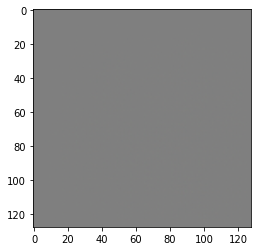

In [0]:
noise = tf.random.normal([1, latent_noise_dim])
generator_output = generator(noise)

plt.imshow((generator_output[0, :, :, :] + 1) * .5)

### The Discriminator

In [0]:
def create_discriminator():
  model = tf.keras.Sequential()

  ## Expects input of shape (BATCH_SIZE, 128, 128, 3)
  model.add(Conv2D(8, (5,5), strides=(2,2), padding='same',
                   input_shape = [WIDTH, HEIGHT, CHANNELS]))
  model.add(LeakyReLU())

  ## Shape => (BATCH_SIZE, 64, 64, 8)
  model.add(Conv2D(32, (5,5), strides=(2,2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  ## Shape => (BATCH_SIZE, 32, 32, 32)
  model.add(Conv2D(64, (5,5), strides=(2,2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  ## Shape => (BATCH_SIZE, 16, 16, 64)
  model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  ## Shape => (BATCH_SIZE, 8, 8, 128)
  model.add(Conv2D(128, (3,3), strides=(1,1), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())


  model.add(Flatten())

  model.add(Dense(8 * 128))
  model.add(LeakyReLU())

  model.add(Dense(2 * 128))
  model.add(LeakyReLU())
  
  model.add(Dense(1))

  return model

In [0]:
## Viewing the Discriminator Model
discriminator = create_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         608       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        6432      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 64)       

In [0]:
discriminator_output = discriminator(generator_output)
print(discriminator_output)

tf.Tensor([[0.00020322]], shape=(1, 1), dtype=float32)


## Defining the Loss Functions and Optimizers

In [0]:
## Need this in our generator and discriminator loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator Loss Function

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

### Generator Loss Function

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Optimizers

In [0]:
# The generator and discriminator each gets its own optimizer
generator_optimizer = tf.keras.optimizers.Adam(12e-5, .5)
discriminator_optimizer = tf.keras.optimizers.Adam(6e-5, .5)

In [0]:
checkpoint_dir = './train_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Defining the Training Loop

In [0]:
## In order to compare our model performance we will use a fixed validation
## seed to generate fixed number of images and see the output of it
no_validation_images = 16
validation_seed = tf.random.normal([no_validation_images, latent_noise_dim])

The training function for one batch receives a array of real images which is random BATCH_SIZE no of samples of train images.


One batch of training function works like this: 
1. Prepare random noise of BATCH_SIZE, latent_dim_shape
2. Get generated images from the generator
3. Get output of dicriminator on Real and Fake (Generated) images
4. Compute loss of generator and discriminator
5. Propogate the loss for each model individually



In [0]:
# Since it will be called repeatedly we use @tf.function annotation
# This will compile the function saving execution time

@tf.function
def train_one_batch(real_images):
  ## Generate random noise
  random_noise = tf.random.normal([BATCH_SIZE, latent_noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    ## Generate images using Generator
    generated_images = generator(random_noise, training = True)

    ## Get the output of dicriminator on real and generate images
    real_output = discriminator(real_images, training = True)
    fake_output = discriminator(generated_images, training=True)

    ## Get loss of generator and dicriminator
    loss_generator = generator_loss(fake_output)
    loss_discriminator = discriminator_loss(real_output, fake_output)

    ## Compute Gradients of generator and dicriminator
    generator_gradients = gen_tape.gradient(loss_generator, 
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(loss_discriminator, 
                                                 discriminator.\
                                                 trainable_variables)
    
    ## Apply backprop using the computed gradients
    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.\
                                                 trainable_variables))
    return loss_generator, loss_discriminator

In [0]:
def fit(dataset, epochs):
  length = len(dataset)
  for epoch in range(1, epochs + 1):
    for idx in tqdm(range(length)):
      batch, _ = next(dataset)
      gen_loss, disc_loss = train_one_batch(batch)
      if idx % 50 == 0:
        print("GLoss: {0} DLoss: {1}".format(gen_loss,
                                            disc_loss))

    display.clear_output(wait=True)
    visualize_validation_output(generator, epoch, validation_seed)

    if (epoch) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
  
  display.clear_output(wait=True)
  visualize_validation_output(generator, epochs + 1, validation_seed)

In [0]:
def visualize_validation_output(model, epoch, validation_seed):
  generated_images = model(validation_seed, training = False)

  fig = plt.figure(figsize = (4,4))

  for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow((generated_images[i, :, :,:] + 1) * .5)
    plt.axis('off')
  
  fig.suptitle('Output at epoch {:03}'.format(epoch))
  plt.savefig('validation_images_{:03}.png'.format(epoch))
  plt.show()

## Training

In [0]:
fit(data_generator, 80)

## Creating GIF

In [0]:
import glob
import imageio

In [0]:
gif_file = 'model_behaviour.gif'

with imageio.get_writer(gif_file, mode='I') as writer:
  filenames = glob.glob('val*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    ## As the epoch increases we will delay the time
    ## before the next frame comes in thus making sure
    ## that the end epochs are clearly visible
    frame = 1.5 * (i**(i/(i+1)))   
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)